In [1]:
import sys
sys.path.insert(0, "../../python")

import os
from ionization import ionization
from ionization import adk
from propagation import propagation
from propagation import laser
from propagation import plasma
from lens import profile
from lens import bessel
from lens import ray
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import integrate
from numpy.fft import fft, ifft, fft2, ifft2, fftfreq, fftshift
from scipy.special import jn
from ht import intht
path = '/media/robert/Data_Storage/Data/Ionization/RayBesselMultiMode/Test/'

In [2]:
# Create the desired intensity profile
ion = {'atom' : ionization.H2,
       'tau' : 35,
       'type' : 'gaussian'}
z0 = 0.75e6
zf = 50e6
dz = 0.5e6
sigmaIn = 15e4
sigmaOut = 15e4
N = 50000
z, I = profile.smoothed_gaussian_ramps(z0, dz, sigmaIn, sigmaOut, ion, N, zf)

Ez = ionization.field_from_intensity(I)

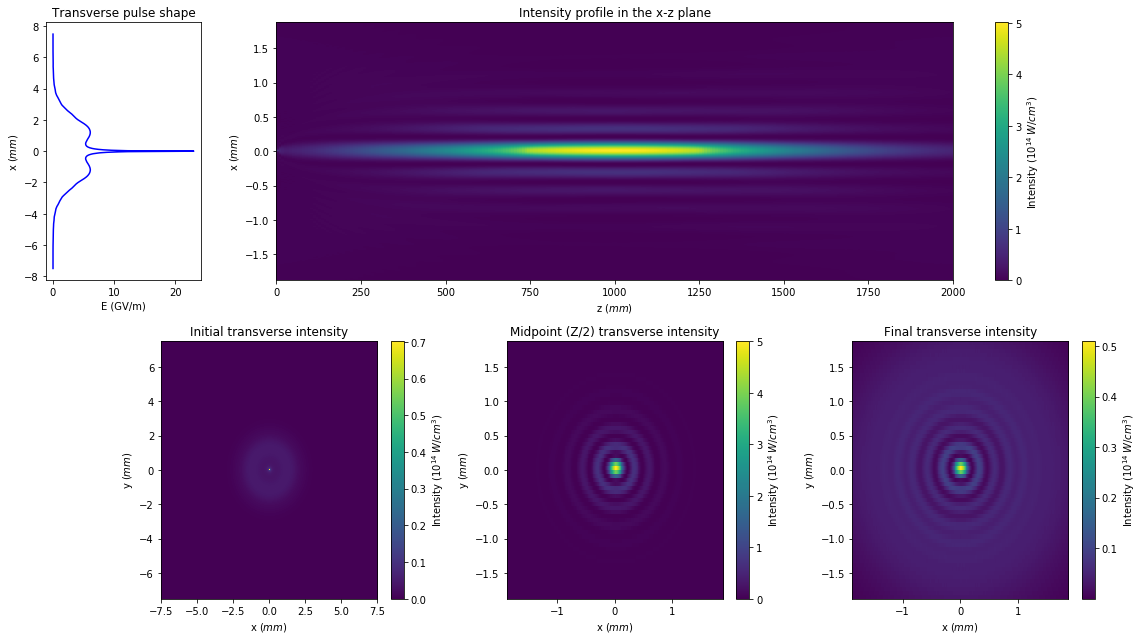

In [3]:
besselParams = {'N' : 1000,
                'M' : 1000,
                'R' : 0.200e3,
                'lam' : 0.8,
                'rmax' : 15e3,}
rm, E = bessel.uniform_bessel(besselParams, Ez, z)
E *= 8.15e6
prop = {'Nx' : 2**10,
        'Ny' : 2**8,
        'Nz' : 2**8,
        'X' : 15e3,
        'Y' : 15e3,
        'Z' : 2e6,
        'E0' : 1.0,
        'lam' : 0.8,
        'n' : 1.0
        }
prop['Efield'] = interp1d(rm, E)
prop['path'] = path + 'Bessel_0/'

def Efunc(x, y): 
    r = np.sqrt(x**2 + y**2)
    Efield = prop['Efield']
    E0 = Efield(r)
    return E0

propagation.laser_prop(prop, Efunc)
propagation.laser_prop_plot(prop['path'])

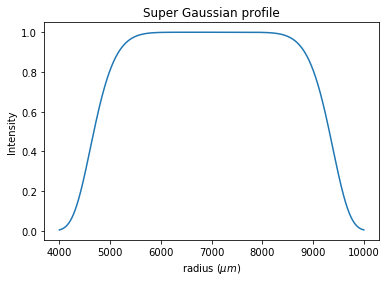

In [4]:
# Lets first generate the super Gaussian profile
r0 = 4e3
R = 10e3
w = 2.65e3
n = 8 # super Gaussian order
rin = np.linspace(r0, R, 1000)
I0 = np.exp(-2*((rin-0.5*(R+r0))/w)**n)

plt.plot(rin, I0)
plt.title('Super Gaussian profile')
plt.xlabel(r'radius ($\mu m$)')
plt.ylabel(r'Intensity')
plt.show()

/home/robert/anaconda3/envs/CU-PWFA/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:554: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


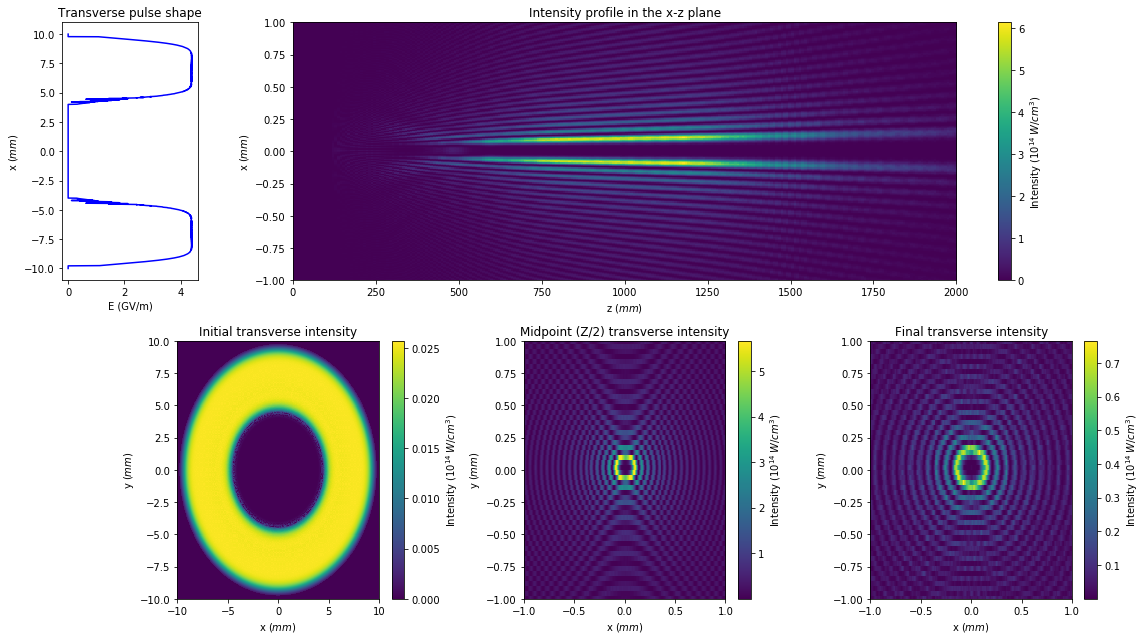

In [5]:
Iamp, r1, phi = ray.arbitrary_phase(I0, rin, I, z, r0=r0, m=0.501)
k = 2*np.pi/prop['lam']
E1 = ionization.field_from_intensity(Iamp*np.exp(-2*((r1-0.5*(R+r0))/w)**n))*np.exp(1j*k*phi)

prop = {'Nx' : 2**11,
        'Ny' : 2**9,
        'Nz' : 2**8,
        'X' : 20e3,
        'Y' : 20e3,
        'Z' : 2e6,
        'E0' : 1.0,
        'lam' : 0.8,
        'n' : 1.0,
        'order' : 4,
        'xlim' : [-1, 1],
        'crosslim' : [-1, 1]
        }
prop['Efield'] = interp1d(r1, E1, bounds_error=False, fill_value=0.0)
prop['path'] = path + 'Bessel_1/'

def Efunc(x, y): # This is complicated because of the atan range
    r = np.sqrt(x**2 + y**2)
    Efield = prop['Efield']
    phi = np.zeros(np.shape(r)) 
    # Handle when x/y -> ininity
    phi[int(prop['Nx']/2), int(prop['Ny']/2):] = np.pi/2
    phi[int(prop['Nx']/2), :int(prop['Ny']/2)] = -np.pi/2
    # Handle the positive x half plane
    sel = np.array(x > 0)
    xp = x[sel]
    xp = np.reshape(xp, (np.size(xp), 1))
    phi[int(prop['Nx']/2+1):, :] = np.arctan(y/xp)
    # Handle the negative x half plane
    sel = np.array(x < 0)
    xn = x[sel]
    xn = np.reshape(xn, (np.size(xn), 1))
    phi[:int(prop['Nx']/2), :] = np.arctan(y/xn) + np.pi
    E0 = Efield(r) * np.exp(1j*prop['order']*phi)
    return E0

propagation.laser_prop(prop, Efunc)
propagation.laser_prop_plot(prop['path'])

Completed time slice  1  of  64
Completed time slice  2  of  64
Completed time slice  3  of  64
Completed time slice  4  of  64
Completed time slice  5  of  64
Completed time slice  6  of  64
Completed time slice  7  of  64
Completed time slice  8  of  64
Completed time slice  9  of  64
Completed time slice  10  of  64
Completed time slice  11  of  64
Completed time slice  12  of  64
Completed time slice  13  of  64
Completed time slice  14  of  64
Completed time slice  15  of  64
Completed time slice  16  of  64
Completed time slice  17  of  64
Completed time slice  18  of  64
Completed time slice  19  of  64
Completed time slice  20  of  64
Completed time slice  21  of  64
Completed time slice  22  of  64
Completed time slice  23  of  64
Completed time slice  24  of  64
Completed time slice  25  of  64
Completed time slice  26  of  64
Completed time slice  27  of  64
Completed time slice  28  of  64
Completed time slice  29  of  64
Completed time slice  30  of  64
Completed time slic

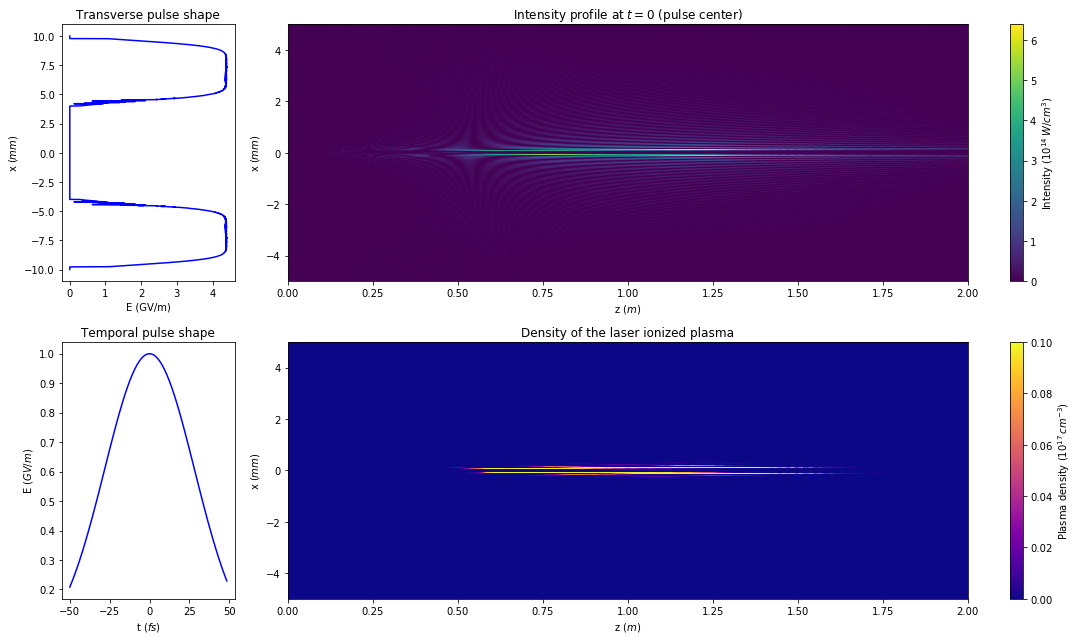

In [7]:
EsourcePath = path + 'Bessel_1/'
modePar = np.load(EsourcePath+'params.npy').item()
modePar['Esource'] = EsourcePath
modePar['nFinal'] = True
modePar['path'] = path + 'RefractionTest/Mode1/'
modePar['Nt'] = 2**6
modePar['T'] = 100
modePar['n0'] = 0.1
modePar['alpha'] = 0.787
modePar['EI'] = 15.426

def Efunc(x, y):
    E0 = np.load(modePar['Esource']+'inputField.npy')
    return E0

# Temporal pulse
def Tfunc(t):
    from ionization import ionization
    tau = 50
    E = ionization.gaussian_envelope(1.0, t, tau).real
    E = E/np.amax(E)
    return E

if not os.path.exists(modePar['path']):
    os.makedirs(modePar['path'])
plasma.plasma_refraction(modePar, Efunc, Tfunc)
plasma.summary_plot(modePar['path'])

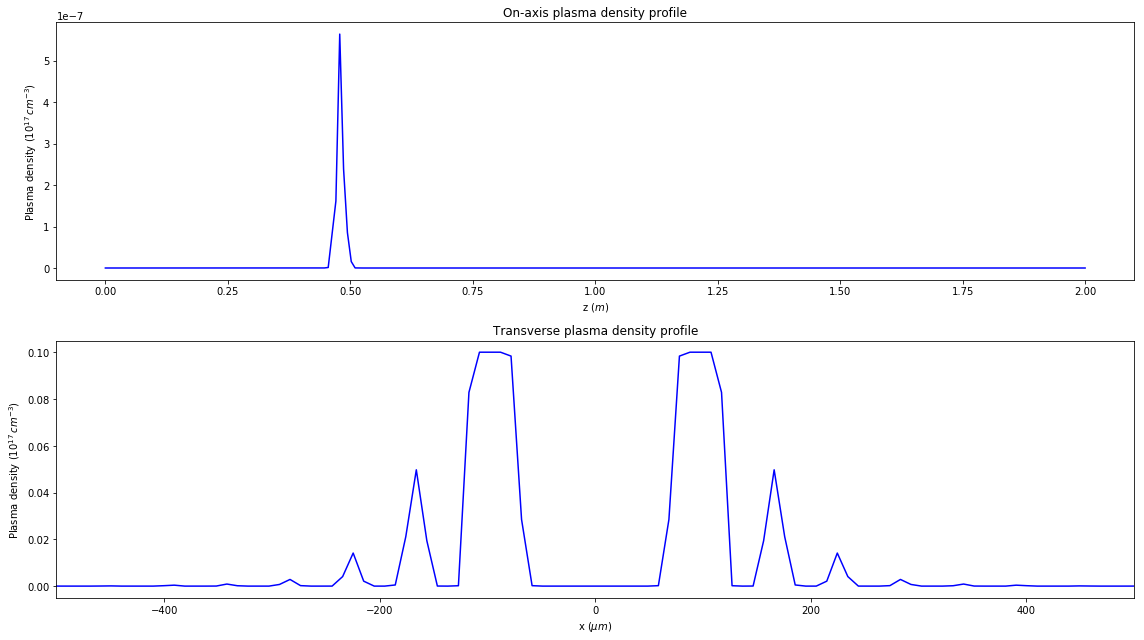

In [9]:
plasma.profile_plot(modePar['path'], xlim=[-500, 500])

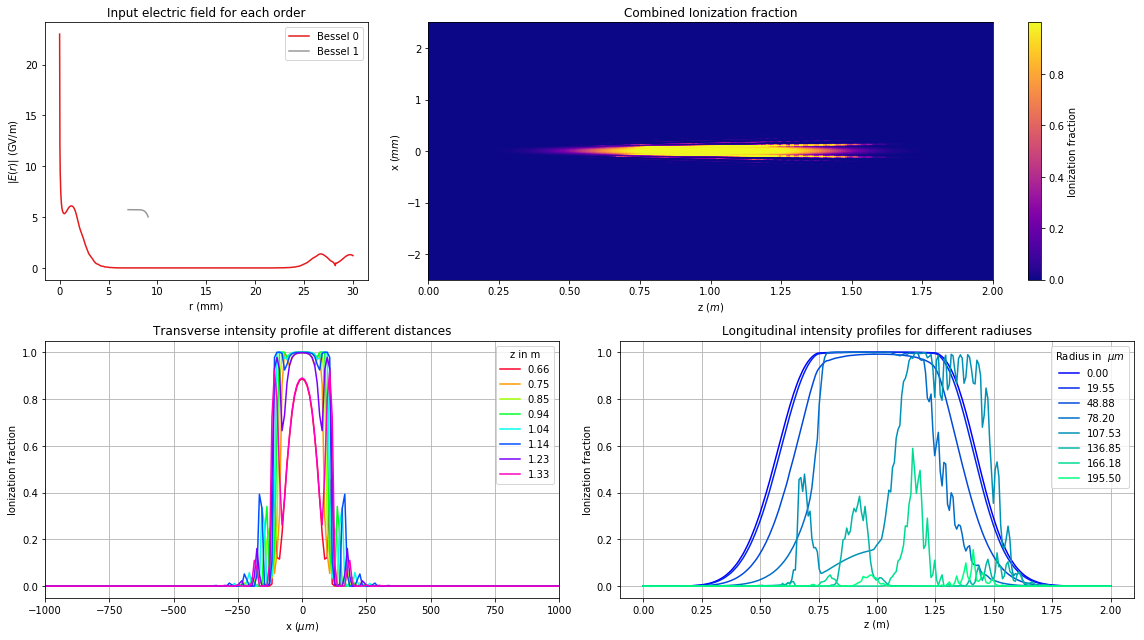

In [3]:
# Lets test the function for creating these optical elements
# Caculate the unrefracted beams
prop = {'Nx' : 2**11,
        'Ny' : 2**9,
        'Nz' : 2**8,
        'X' : 20e3,
        'Y' : 20e3,
        'Z' : 2e6,
        'E0' : 1.0,
        'lam' : 0.8,
        'n' : 1.0
        }
params = {'L' : 2,
          'N' : 1000,
          'M' : 1000,
          'R' : 0.20e3,
          'lam' : 0.8,
          'rmax' : [30e3, 30e3],
          'r0' : [7e3],
          'w' : [2.65e3],
          'nGauss' : [8],
          'm' : [1.0],
          'prop' : prop,
          'order' : [0, 4],
          'atom' : ionization.H2,
          'tau' : ion['tau'],
          'multi' : [1.0, 1.7],
          'xlim' : [-1000, 1000]
         }
params['path'] = path + 'funcTest'

#bessel.multimode_lens_ionization(params, z, I)
bessel.ionization_plot(params['path'], 8, dr=25)